<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science </h1>

## Final Project -- Predicting Types of Crime
### Data Cleaning


**Group 16**: Crystal Ma, Qian Xiao, and Yenan Xu



<hr style='height:2px'>

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from uszipcode import SearchEngine


%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

## Read in Dataframe from Analyze Boston analytics

In [103]:
#Read in the light dataframe from Analyze Boston analytics
df_lights = pd.read_csv('https://data.boston.gov/dataset/52b0fdad-4037-460c-9c92-290f5774ab2b/resource/c2fcc1e3-c38f-44ad-a0cf-e5ea2a6585b5/download/streetlight-locations.csv')

df_lights.head()

,the_geom,OBJECTID,TYPE,Lat,Long
0,POINT (-71.0760443807948 42.35315925057316),1,LIGHT,42.353159,-71.076044
1,POINT (-71.07538171240694 42.353347768071195),2,LIGHT,42.353348,-71.075382
2,POINT (-71.07477488057383 42.35352052068278),3,LIGHT,42.353521,-71.074775
3,POINT (-71.07440373484715 42.3535558201314),4,LIGHT,42.353556,-71.074404
4,POINT (-71.07362079549182 42.35381056415504),5,LIGHT,42.353811,-71.073621


In [67]:
# Read in the crime dataframe from Analyze Boston analytics
df_crime = pd.read_csv('https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmp9oic1oj9.csv')

# Drop incidents with missing geographical information (including coordinates [-1, -1])
df_crime = df_crime.dropna(subset=['STREET', 'Lat', 'Long'])
df_crime = df_crime[df_crime['Lat'] != -1]
df_crime = df_crime.reset_index(drop=True)

df_crime.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I192082859,724,Auto Theft,AUTO THEFT,E18,519,NaN,2019-10-13 09:28:24,2019,10,Sunday,9,Part One,LINCOLN ST,42.259518,-71.121563,"(42.25951765, -71.12156299)"
1,I192082751,724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)"
2,I192082680,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,D14,794,NaN,2019-10-12 15:12:43,2019,10,Saturday,15,Part One,ALLSTON ST,42.352375,-71.135096,"(42.35237455, -71.13509584)"
3,I192082577,724,Auto Theft,AUTO THEFT,D4,130,NaN,2019-10-12 04:41:52,2019,10,Saturday,4,Part One,SAINT JAMES AVE,42.349476,-71.076402,"(42.34947586, -71.07640150)"
4,I192079582,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,A15,47,NaN,2019-10-02 08:08:49,2019,10,Wednesday,8,Part One,N MEAD ST,42.381846,-71.066551,"(42.38184582, -71.06655134)"


In [7]:
# Read in the property assessment dataframe from Analyze Boston analytics
df_property = pd.read_csv('https://data.boston.gov/dataset/e02c44d2-3c64-459c-8fe2-e1ce5f38a035/resource/695a8596-5458-442b-a017-7cd72471aade/download/fy19fullpropassess.csv')

# Drop obervations with missing geographical information
df_property_output = df_property.dropna(subset=['ST_NAME', 'ZIPCODE'])
df_property_output = df_property_output.reset_index(drop=True)

/Users/autumn/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# Check for missing values
nan_count = []
zero_count = []
for c in df_property.columns:
    nan_count.append(df_property_output[c].isnull().sum())
    zero_count.append(df_property_output[df_property_output[c] == 0][c].count())

df_zn = pd.DataFrame(data={'nan_count': nan_count, 'zero_count': zero_count}, index=df_property_output.columns.values)

df_zn['nan_perc'] = df_zn['nan_count']/df_property_output.shape[0]
df_zn['zero_perc'] = df_zn['zero_count']/df_property_output.shape[0]

df_zn[(df_zn['nan_perc'] > 0.5) | (df_zn['zero_perc'] > 0.5)]

,nan_count,zero_count,nan_perc,zero_perc
CM_ID,92628,0,0.530330,0.000000
UNIT_NUM,108962,0,0.623848,0.000000
STRUCTURE_CLASS,90161,0,0.516206,0.000000
R_BLDG_STYL,111901,0,0.640675,0.000000
R_ROOF_TYP,111904,0,0.640693,0.000000
R_EXT_FIN,111904,0,0.640693,0.000000
R_TOTAL_RMS,111904,0,0.640693,0.000000
R_BDRMS,111904,6,0.640693,0.000034
R_FULL_BTH,111904,4,0.640693,0.000023
R_HALF_BTH,111904,41686,0.640693,0.238668


In [9]:
# Keep Quantitative variables with missing values no more than 50%
P_columns = ['ST_NAME', 'ST_NAME_SUF', 'ZIPCODE', 'PTYPE', 'AV_BLDG', 'AV_TOTAL', 'GROSS_TAX', 'LAND_SF', 
             'YR_BUILT', 'YR_REMOD', 'GROSS_AREA', 'LIVING_AREA', 'NUM_FLOORS']
df_property_output = df_property_output[P_columns]

df_property_output.head()

,ST_NAME,ST_NAME_SUF,ZIPCODE,PTYPE,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,GROSS_AREA,LIVING_AREA,NUM_FLOORS
0,BEACON,ST,2108.0,102,878200,878200,925623,789.0,1850.0,2006.0,789.0,789.0,1.0
1,BEACON,ST,2108.0,102,817600,817600,861750,752.0,1850.0,1981.0,752.0,752.0,1.0
2,BEACON,ST,2108.0,102,849500,849500,895373,792.0,1850.0,2016.0,792.0,792.0,1.0
3,BEACON,ST,2108.0,102,734400,734400,774058,720.0,1850.0,1981.0,720.0,720.0,1.0
4,BEACON,ST,2108.0,102,2162300,2162300,2279064,1482.0,1850.0,2014.0,1482.0,1482.0,1.0


----

## Data Cleaning -- Property Assessment Dataset

In [10]:
# Transform 'ZIPCODE' to string
zip_codes = df_property_output['ZIPCODE']
zip_codes_ls = [zip_codes.iloc[i,] for i in range(zip_codes.shape[0])]
df_property_output['ZIPCODE'] = [str(0)+str(int(i)) for i in zip_codes_ls]

In [11]:
# Get the first and second words from 'ST_NAME'
st_name = df_property_output['ST_NAME']
st_name_ls = [st_name.iloc[i,] for i in range(st_name.shape[0])]

P_ST_NAME_1st = []
P_ST_NAME_2nd = []
for i in range(len(st_name_ls)):
    ST_Name = ' '.join(st_name_ls[i].lstrip().rstrip().split("'")).split(" ")
    
    if (len(ST_Name[0]) == 1) & (len(ST_Name) > 1):
        P_ST_NAME_1st.append(ST_Name[0]+ST_Name[1])
    else:
        P_ST_NAME_1st.append(ST_Name[0])
        
    if len(ST_Name) > 1:
        P_ST_NAME_2nd.append(ST_Name[1])
    else:
        P_ST_NAME_2nd.append(np.nan)   
        
df_property_output['ST_NAME_1st'] = P_ST_NAME_1st
df_property_output['ST_NAME_2nd'] = P_ST_NAME_2nd
df_property_output['ST_NAME_2nd'] = df_property_output['ST_NAME_2nd'].replace('',np.nan)

In [12]:
# Clean 'ST_NAME_SUF'
df_property_output['ST_NAME_SUF'] = df_property_output['ST_NAME_SUF'].replace(np.nan,'')
df_property_output['ST_NAME_SUF'] = [df_property_output['ST_NAME_SUF'][i].strip() for i in range(df_property_output.shape[0])]
df_property_output['ST_NAME_SUF'] = df_property_output['ST_NAME_SUF'].replace('', np.nan)

In [13]:
# For better matching
df_property_output.loc[df_property_output['ST_NAME_SUF']=='AVE', 'ST_NAME_SUF'] = 'AV'
df_property_output.loc[df_property_output['ST_NAME']=='MARSHALL BLOCK', 'ST_NAME_SUF'] = 'BL'
df_property_output.loc[df_property_output['ST_NAME']=='BOSTON UNI BRIDGE ZZ', 'ST_NAME_SUF'] = 'BG'
df_property_output.loc[df_property_output['ST_NAME']=='FENWAY', 'ST_NAME_SUF'] = 'ST'
df_property_output.loc[df_property_output['ST_NAME']=='WM F MCCLELLAN', 'ST_NAME_1st'] = 'WILLIAM'
df_property_output.loc[df_property_output['ST_NAME']=='GEN WM H DEVINE', 'ST_NAME_1st'] = 'GENERAL'
df_property_output.loc[df_property_output['ST_NAME']=='GEN WM H DEVINE', 'ST_NAME_2nd'] = 'WILLIAM'
df_property_output.loc[df_property_output['ST_NAME']=='GEN JOZEF PILSUDSKI', 'ST_NAME_1st'] = 'GENERAL'
df_property_output.loc[df_property_output['ST_NAME']=='MSGR ALBERT A JACOBBE', 'ST_NAME_1st'] = 'MONSIGNOR'
df_property_output.loc[df_property_output['ST_NAME']=='JAMAICAWAY', 'ST_NAME_SUF'] = 'ST'
df_property_output.loc[df_property_output['ST_NAME']=='AVENUE DE LAFAYETTE', 'ST_NAME_1st'] = 'LAFAYETTE'
df_property_output.loc[df_property_output['ST_NAME']=='AVENUE DE LAFAYETTE', 'ST_NAME_SUF'] = 'AV'
df_property_output.loc[df_property_output['ST_NAME']=='AVENUE LOUIS PASTEUR', 'ST_NAME_1st'] = 'PASTEUR'
df_property_output.loc[df_property_output['ST_NAME']=='AVENUE LOUIS PASTEUR', 'ST_NAME_SUF'] = 'AV'
df_property_output.loc[df_property_output['ST_NAME']=='TRUMAN', 'ST_NAME_SUF'] = 'PW'
df_property_output.loc[df_property_output['ST_NAME_SUF']=='LA', 'ST_NAME_SUF'] = 'LN'
df_property_output.loc[df_property_output['ST_NAME']=='MSGR P J LYDON', 'ST_NAME_1st'] = 'MONSIGNOR'
df_property_output.loc[df_property_output['ST_NAME']=='MSGR P J LYDON', 'ST_NAME_2nd'] = 'PATRICK'
df_property_output.loc[df_property_output['ST_NAME']=='RIVERWAY', 'ST_NAME_SUF'] = 'ST'
df_property_output.loc[df_property_output['ST_NAME']=='PARLEY VALE', 'ST_NAME_SUF'] = 'ST'

In [14]:
# Categorize 'PTYPE'
df_property_output['PTYPE_ca'] = np.nan
df_property_output.loc[df_property_output['PTYPE'] <= 31, 'PTYPE_ca'] = 'MU'
df_property_output.loc[(df_property_output['PTYPE'] >= 101)&(df_property_output['PTYPE'] <= 110), 'PTYPE_ca'] = 'R'
df_property_output.loc[(df_property_output['PTYPE'] >= 111)&(df_property_output['PTYPE'] <= 211), 'PTYPE_ca'] = 'A'
df_property_output.loc[(df_property_output['PTYPE'] >= 300)&(df_property_output['PTYPE'] <= 399), 'PTYPE_ca'] = 'C'
df_property_output.loc[(df_property_output['PTYPE'] >= 400)&(df_property_output['PTYPE'] <= 465), 'PTYPE_ca'] = 'I'
df_property_output.loc[(df_property_output['PTYPE'] >= 900)&(df_property_output['PTYPE'] <= 925), 'PTYPE_ca'] = 'EO'
df_property_output.loc[(df_property_output['PTYPE'] >= 937)&(df_property_output['PTYPE'] <= 999), 'PTYPE_ca'] = 'EP'

In [15]:
# One-hot encoding for 'PTYPE'
df_property_output['PTYPE_cate'] = df_property_output['PTYPE_ca']
df_property_output = pd.get_dummies(df_property_output, columns = ['PTYPE_ca'], prefix='PTYPE', drop_first=False)

In [16]:
# Modify 'YR_BUILT' by subtracting the median
bm = df_property_output[df_property_output['YR_BUILT'] != 0]['YR_BUILT'].median()
df_property_output['YR_BUILT_m'] = df_property_output['YR_BUILT'] - bm
df_property_output.loc[df_property_output['YR_BUILT_m'] == -bm, 'YR_BUILT_m'] = np.nan

In [17]:
# Modify 'YR_REMOD' by subtracting the median
rm = df_property_output[df_property_output['YR_REMOD'] != 0]['YR_REMOD'].median()
df_property_output['YR_REMOD_m'] = df_property_output['YR_REMOD'] - rm
df_property_output.loc[df_property_output['YR_REMOD_m'] == -rm, 'YR_REMOD_m'] = np.nan

In [18]:
# Combine 'ST_NAME_1st', 'ST_NAME_2nd' and 'ST_NAME_SUF'
df_property_output['ST_NAME_1st'] = df_property_output['ST_NAME_1st'].replace(np.nan, 'NNaN')
df_property_output['ST_NAME_2nd'] = df_property_output['ST_NAME_2nd'].replace(np.nan, 'NNaN')
df_property_output['ST_NAME_SUF'] = df_property_output['ST_NAME_SUF'].replace(np.nan, 'NNaN')

df_property_output.loc[(df_property_output['ST_NAME_2nd'] == 'NNaN')|(df_property_output['ST_NAME_2nd'] == df_property_output['ST_NAME_SUF']),'ST_comb'] = df_property_output['ST_NAME_1st'] +' '+ df_property_output['ST_NAME_SUF']
df_property_output.loc[(df_property_output['ST_NAME_2nd'] != 'NNaN')&(df_property_output['ST_NAME_2nd'] != df_property_output['ST_NAME_SUF']),'ST_comb'] = df_property_output['ST_NAME_1st'] +' '+ df_property_output['ST_NAME_2nd'] +' '+ df_property_output['ST_NAME_SUF']

df_property_output['ST_12'] = df_property_output['ST_NAME_1st'] +' '+ df_property_output['ST_NAME_2nd']
df_property_output['ST_1SUF'] = df_property_output['ST_NAME_1st'] +' '+ df_property_output['ST_NAME_SUF']

df_property_output.head()

,ST_NAME,ST_NAME_SUF,ZIPCODE,PTYPE,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,GROSS_AREA,LIVING_AREA,NUM_FLOORS,ST_NAME_1st,ST_NAME_2nd,PTYPE_cate,PTYPE_A,PTYPE_C,PTYPE_EO,PTYPE_EP,PTYPE_I,PTYPE_MU,PTYPE_R,YR_BUILT_m,YR_REMOD_m,ST_comb,ST_12,ST_1SUF
0,BEACON,ST,02108,102,878200,878200,925623,789.0,1850.0,2006.0,789.0,789.0,1.0,BEACON,NNaN,R,0,0,0,0,0,0,1,-65.0,5.0,BEACON ST,BEACON NNaN,BEACON ST
1,BEACON,ST,02108,102,817600,817600,861750,752.0,1850.0,1981.0,752.0,752.0,1.0,BEACON,NNaN,R,0,0,0,0,0,0,1,-65.0,-20.0,BEACON ST,BEACON NNaN,BEACON ST
2,BEACON,ST,02108,102,849500,849500,895373,792.0,1850.0,2016.0,792.0,792.0,1.0,BEACON,NNaN,R,0,0,0,0,0,0,1,-65.0,15.0,BEACON ST,BEACON NNaN,BEACON ST
3,BEACON,ST,02108,102,734400,734400,774058,720.0,1850.0,1981.0,720.0,720.0,1.0,BEACON,NNaN,R,0,0,0,0,0,0,1,-65.0,-20.0,BEACON ST,BEACON NNaN,BEACON ST
4,BEACON,ST,02108,102,2162300,2162300,2279064,1482.0,1850.0,2014.0,1482.0,1482.0,1.0,BEACON,NNaN,R,0,0,0,0,0,0,1,-65.0,13.0,BEACON ST,BEACON NNaN,BEACON ST


In [19]:
# Groupby 'ST_comb', 'ST_1SUF' and 'ST_12'
def ST_group(column):
    df_group = df_property_output.groupby(by = [column], as_index=False).agg({
                                                        'ST_NAME_1st': 'first',
                                                        'ST_NAME_2nd': 'first',
                                                        'ST_NAME_SUF': 'first',
                                                        'ZIPCODE': 'first',
                                                        'AV_BLDG': 'mean',
                                                        'AV_TOTAL': 'mean',
                                                        'GROSS_TAX': 'mean',
                                                        'LAND_SF': 'mean',
                                                        'GROSS_AREA': 'mean',
                                                        'LIVING_AREA': 'mean',
                                                        'NUM_FLOORS': 'mean',
                                                        'PTYPE_A': 'sum',
                                                        'PTYPE_C': 'sum',
                                                        'PTYPE_EO': 'sum',
                                                        'PTYPE_EP': 'sum',
                                                        'PTYPE_I': 'sum',
                                                        'PTYPE_MU': 'sum',
                                                        'PTYPE_R': 'sum',
                                                        'YR_BUILT_m': 'mean',
                                                        'YR_REMOD_m': 'mean'})
    return df_group

In [20]:
df_property_groupby_comb = ST_group('ST_comb')
df_property_groupby_1SUF = ST_group('ST_1SUF')
df_property_groupby_12 = ST_group('ST_12')

In [21]:
df_property_groupby_comb.head()

,ST_comb,ST_NAME_1st,ST_NAME_2nd,ST_NAME_SUF,ZIPCODE,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,GROSS_AREA,LIVING_AREA,NUM_FLOORS,PTYPE_A,PTYPE_C,PTYPE_EO,PTYPE_EP,PTYPE_I,PTYPE_MU,PTYPE_R,YR_BUILT_m,YR_REMOD_m
0,A ST,A,NNaN,ST,02127,1.515448e+06,2.174722e+06,3.050204e+06,7304.124088,4764.060606,4457.522727,1.756757,0,25.0,0,13.0,7,4,92.0,77.467290,-2.840000
1,ABBOT ST,ABBOT,NNaN,ST,02124,4.402417e+05,6.464932e+05,6.035667e+05,6051.750000,5756.687500,3965.000000,2.741935,5,0.0,1,2.0,0,1,23.0,17.451613,0.875000
2,ABBOTSFORD ST,ABBOTSFORD,NNaN,ST,02121,3.067391e+05,4.051522e+05,4.270304e+05,3862.043478,5316.347826,3524.695652,2.021739,1,0.0,0,2.0,0,0,20.0,6.869565,5.133333
3,ABBOTT ST,ABBOTT,NNaN,ST,02124,2.067000e+05,2.067000e+05,2.178620e+05,1499.000000,1499.000000,1046.000000,2.000000,0,0.0,0,0.0,0,0,1.0,73.000000,NaN
4,ABBY RD,ABBY,NNaN,RD,02135,4.115545e+05,5.708273e+05,4.376176e+05,5368.363636,2745.454545,2151.636364,2.333333,1,2.0,1,1.0,0,0,6.0,15.777778,3.500000


In [22]:
df_property_groupby_1SUF.head()

,ST_1SUF,ST_NAME_1st,ST_NAME_2nd,ST_NAME_SUF,ZIPCODE,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,GROSS_AREA,LIVING_AREA,NUM_FLOORS,PTYPE_A,PTYPE_C,PTYPE_EO,PTYPE_EP,PTYPE_I,PTYPE_MU,PTYPE_R,YR_BUILT_m,YR_REMOD_m
0,A ST,A,NNaN,ST,02127,1.515448e+06,2.174722e+06,3.050204e+06,7304.124088,4764.060606,4457.522727,1.756757,0,25.0,0,13.0,7,4,92.0,77.467290,-2.840000
1,ABBOT ST,ABBOT,NNaN,ST,02124,4.402417e+05,6.464932e+05,6.035667e+05,6051.750000,5756.687500,3965.000000,2.741935,5,0.0,1,2.0,0,1,23.0,17.451613,0.875000
2,ABBOTSFORD ST,ABBOTSFORD,NNaN,ST,02121,3.067391e+05,4.051522e+05,4.270304e+05,3862.043478,5316.347826,3524.695652,2.021739,1,0.0,0,2.0,0,0,20.0,6.869565,5.133333
3,ABBOTT ST,ABBOTT,NNaN,ST,02124,2.067000e+05,2.067000e+05,2.178620e+05,1499.000000,1499.000000,1046.000000,2.000000,0,0.0,0,0.0,0,0,1.0,73.000000,NaN
4,ABBY RD,ABBY,NNaN,RD,02135,4.115545e+05,5.708273e+05,4.376176e+05,5368.363636,2745.454545,2151.636364,2.333333,1,2.0,1,1.0,0,0,6.0,15.777778,3.500000


In [23]:
df_property_groupby_12.head()

,ST_12,ST_NAME_1st,ST_NAME_2nd,ST_NAME_SUF,ZIPCODE,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,GROSS_AREA,LIVING_AREA,NUM_FLOORS,PTYPE_A,PTYPE_C,PTYPE_EO,PTYPE_EP,PTYPE_I,PTYPE_MU,PTYPE_R,YR_BUILT_m,YR_REMOD_m
0,A NNaN,A,NNaN,ST,02127,1.515448e+06,2.174722e+06,3.050204e+06,7304.124088,4764.060606,4457.522727,1.756757,0,25.0,0,13.0,7,4,92.0,77.467290,-2.840000
1,ABBOT NNaN,ABBOT,NNaN,ST,02124,4.402417e+05,6.464932e+05,6.035667e+05,6051.750000,5756.687500,3965.000000,2.741935,5,0.0,1,2.0,0,1,23.0,17.451613,0.875000
2,ABBOTSFORD NNaN,ABBOTSFORD,NNaN,ST,02121,3.067391e+05,4.051522e+05,4.270304e+05,3862.043478,5316.347826,3524.695652,2.021739,1,0.0,0,2.0,0,0,20.0,6.869565,5.133333
3,ABBOTT NNaN,ABBOTT,NNaN,ST,02124,2.067000e+05,2.067000e+05,2.178620e+05,1499.000000,1499.000000,1046.000000,2.000000,0,0.0,0,0.0,0,0,1.0,73.000000,NaN
4,ABBY NNaN,ABBY,NNaN,RD,02135,4.115545e+05,5.708273e+05,4.376176e+05,5368.363636,2745.454545,2151.636364,2.333333,1,2.0,1,1.0,0,0,6.0,15.777778,3.500000


------

## Data Cleaning -- Crime Dataset

In [68]:
#Add a column for time selection
df_crime.OCCURRED_ON_DATE = pd.to_datetime(df_crime.OCCURRED_ON_DATE)
df_crime['OCCURED_TIME']= pd.to_datetime(df_crime.OCCURRED_ON_DATE.dt.time, format = '%H:%M:%S').apply(pd.Timestamp)

In [69]:
#Subset the dataframe into different months, and select the crimes that occured during dark time
df_nov_feb = df_crime[(df_crime.OCCURED_TIME > '1900-1-1 17:00:00')|(df_crime.OCCURED_TIME < '1900-1-1 06:00:00') 
                      & (df_crime.MONTH.isin([1,2,11,12]))]
df_oct_apr = df_crime[(df_crime.OCCURED_TIME > '1900-1-1 19:30:00')|(df_crime.OCCURED_TIME < '1900-1-1 05:00:00') 
                      & (df_crime.MONTH.isin([9,10,3,4]))]
df_may_aug = df_crime[(df_crime.OCCURED_TIME > '1900-1-1 20:30:00')|(df_crime.OCCURED_TIME < '1900-1-1 04:00:00') 
                      & (df_crime.MONTH.isin([5,6,7,8]))]

In [70]:
#Merge the datasets of different months together 
df_crime_dark = pd.concat([df_nov_feb, df_oct_apr, df_may_aug])

In [71]:
#Create a offense code group list for crime type selection
offense_codes_gr_ls = list(set(df_crime['OFFENSE_CODE_GROUP']))
offense_codes_gr_ls = [i for i in offense_codes_gr_ls if str(i) != 'nan' ]#excluding NaN from the list

In [72]:
theft_codes = []#list of offense codes that can be grouped into "theft"
for code in offense_codes_gr_ls:
    if 'Larceny' in code:#if the offense codes contain larceny, burglary or theft, attach them to the list
        theft_codes.append(code)
    elif 'Burglary' in code:
        theft_codes.append(code)
    elif 'Theft' in code:
        theft_codes.append(code)

theft_codes.remove('Auto Theft Recovery')

#Similar steps for robbery, drug abuse violations, assaults, vandalism and motor/vehicle accidents.
rob_codes = []
for code in offense_codes_gr_ls:
    if 'Robbery' in code:
        rob_codes.append(code)
        
drug_codes = []
for code in offense_codes_gr_ls:
    if 'Drug' in code:
        drug_codes.append(code)

assault_codes = []
for code in offense_codes_gr_ls:
    if 'Assault' in code:
        assault_codes.append(code)
    elif 'Battery' in code:
        assault_codes.append(code)
    elif 'Harassment' in code:
        assault_codes.append(code)

vandalism_codes = []
for code in offense_codes_gr_ls:
    if 'Vandalism' in code:
        vandalism_codes.append(code)
        
mv_accident_codes = ['Motor Vehicle Accident Response']

In [74]:
idx_ls = [] #list of indices of the selected crime cases
output_ls = [] #list of crime types coded as numbers
crime_cat_ls = [] #list of crime types as categories
for i in range(len(df_crime_dark)):
    if df_crime_dark.OFFENSE_CODE_GROUP.iloc[i] in theft_codes:
        output_ls.append(0) #if it is theft, coded as 0
        crime_cat_ls.append("Theft")
        idx_ls.append(i)
    elif df_crime_dark.OFFENSE_CODE_GROUP.iloc[i] in rob_codes:
        output_ls.append(1)
        crime_cat_ls.append("Robbery")
        idx_ls.append(i)
    elif df_crime_dark.OFFENSE_CODE_GROUP.iloc[i] in assault_codes:
        output_ls.append(2)
        crime_cat_ls.append("Assault")
        idx_ls.append(i)
    elif df_crime_dark.OFFENSE_CODE_GROUP.iloc[i] in vandalism_codes:
        output_ls.append(3)
        crime_cat_ls.append("Vandalism")
        idx_ls.append(i)
    elif df_crime_dark.OFFENSE_CODE_GROUP.iloc[i] in mv_accident_codes:
        output_ls.append(4)
        crime_cat_ls.append("M/V Accident")
        idx_ls.append(i)
    elif df_crime_dark.OFFENSE_CODE_GROUP.iloc[i] in drug_codes:
        output_ls.append(5)
        crime_cat_ls.append("Drug Abuse Violation")
        idx_ls.append(i)
    else:
        output_ls.append(np.nan)#if not found in any of the wanted offense codes lists, attach NaN
        crime_cat_ls.append(np.nan)

df_crime_dark['Crime_Type'] = output_ls #Attach a new column for crime types to the crime dataset
df_crime_dark['Crime_Type_Cat'] = crime_cat_ls

In [75]:
df_crime_output = df_crime_dark.iloc[idx_ls,] #Subset the crime datasets by including only the crime cases that we have selected

df_crime_output = df_crime_output.reset_index(drop=True)

df_crime_output.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,OCCURED_TIME,Crime_Type,Crime_Type_Cat
0,I192082751,724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)",1900-01-01 20:11:26,0.0,Theft
1,I192078623,3802,Motor Vehicle Accident Response,M/V ACCIDENT - PROPERTY DAMAGE,C11,400,NaN,2019-09-28 22:40:00,2019,9,Saturday,22,Part Three,MONTAGUE ST,42.286065,-71.070010,"(42.28606484, -71.07001038)",1900-01-01 22:40:00,4.0,M/V Accident
2,I192078599,1402,Vandalism,VANDALISM,B2,238,NaN,2019-09-28 23:21:00,2019,9,Saturday,23,Part Two,WENDOVER ST,42.318827,-71.066054,"(42.31882655, -71.06605368)",1900-01-01 23:21:00,3.0,Vandalism
3,I192078594,613,Larceny,LARCENY SHOPLIFTING,D4,619,NaN,2019-09-28 23:57:00,2019,9,Saturday,23,Part One,MASSACHUSETTS AVE,42.344396,-71.086320,"(42.34439568, -71.08632016)",1900-01-01 23:57:00,0.0,Theft
4,I192078586,3802,Motor Vehicle Accident Response,M/V ACCIDENT - PROPERTY DAMAGE,E18,485,NaN,2019-09-28 23:33:00,2019,9,Saturday,23,Part Three,MATTAKEESET ST,42.264837,-71.099668,"(42.26483674, -71.09966819)",1900-01-01 23:33:00,4.0,M/V Accident


In [76]:
# Get the first, second and last words from 'STREET'
street = df_crime_output['STREET']
street_ls = [street.iloc[i,] for i in range(street.shape[0])]

In [77]:
C_ST_NAME_1st = []
C_ST_NAME_2nd = []
C_ST_NAME_SUF = []
for i in range(len(street_ls)):
    ST_Name = ' '.join(street_ls[i].lstrip().rstrip().split("'")).split(" ")
    
    if (len(ST_Name[0]) == 1) & (len(ST_Name) > 1):
        C_ST_NAME_1st.append(ST_Name[0]+ST_Name[1])
    else:
        C_ST_NAME_1st.append(ST_Name[0])
        
    C_ST_NAME_SUF.append(ST_Name[-1])
    
    if len(ST_Name) > 1:
        C_ST_NAME_2nd.append(ST_Name[1])
    else:
        C_ST_NAME_2nd.append(np.nan)            

In [78]:
df_crime_output['ST_NAME_1st'] = C_ST_NAME_1st
df_crime_output['ST_NAME_2nd'] = C_ST_NAME_2nd
df_crime_output['ST_NAME_SUF'] = C_ST_NAME_SUF

In [79]:
# For better matching
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='ALY', 'ST_NAME_SUF'] = 'AL'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='AVE', 'ST_NAME_SUF'] = 'AV'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='BLOCK', 'ST_NAME_SUF'] = 'BL'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='BLV', 'ST_NAME_SUF'] = 'BL'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='BLVD', 'ST_NAME_SUF'] = 'BL'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='BRG', 'ST_NAME_SUF'] = 'BG'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='BROADWAY', 'ST_NAME_1st'] = 'BROADWAY'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='BROADWAY', 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='CIRT', 'ST_NAME_SUF'] = 'CC'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='CIR', 'ST_NAME_SUF'] = 'CI'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='CRES', 'ST_NAME_SUF'] = 'CR'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='CHARLESGATE', 'ST_NAME_SUF'] = np.nan
df_crime_output.loc[df_crime_output['STREET']=='HARRISON AVENUE EXT', 'ST_NAME_SUF'] = 'AV'
df_crime_output.loc[df_crime_output['STREET']=='CHARLESGATE E', ['ST_NAME_2nd', 'ST_NAME_SUF']] = 'EAST'
df_crime_output.loc[df_crime_output['STREET']=='COMMERCIAL WHRF E', 'ST_NAME_SUF'] = 'EAST'
df_crime_output.loc[df_crime_output['STREET']=='CHARLESGATE W', ['ST_NAME_2nd', 'ST_NAME_SUF']] = 'WEST'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='FENWAY', 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='HWY', 'ST_NAME_SUF'] = 'HW'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='MARKETPLACE', 'ST_NAME_SUF'] = np.nan
df_crime_output.loc[df_crime_output['STREET']=='MONSIGNOR PATRICK J. LYDO', 'ST_NAME_SUF'] = 'WY'
df_crime_output.loc[df_crime_output['STREET']=='GENERAL WILLIAM H DEVINE ', 'ST_NAME_SUF'] = 'WY'
df_crime_output.loc[df_crime_output['STREET']=='GENERAL JOZEF PILSUDSKI W', 'ST_NAME_SUF'] = 'WY'
df_crime_output.loc[df_crime_output['STREET']=='OAK ST W', 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['STREET']=='MONSIGNOR ALBERT A. JACOB', 'ST_NAME_SUF'] = 'RD'
df_crime_output.loc[df_crime_output['STREET']=='JAMAICAWAY', 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['STREET']=='AVENUE DE LAFAYETTE', 'ST_NAME_1st'] = 'LAFAYETTE'
df_crime_output.loc[df_crime_output['STREET']=='AVENUE DE LAFAYETTE', 'ST_NAME_SUF'] = 'AV'
df_crime_output.loc[df_crime_output['STREET']=='AVENUE LOUIS PASTEUR', 'ST_NAME_1st'] = 'PASTEUR'
df_crime_output.loc[df_crime_output['STREET']=='AVENUE LOUIS PASTEUR', 'ST_NAME_SUF'] = 'AV'
df_crime_output.loc[df_crime_output['STREET']=='ELM LAWN', 'ST_NAME_SUF'] = np.nan
df_crime_output.loc[df_crime_output['STREET']=='LEXINGTON', 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['STREET']=='ARBORWAY', 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['STREET']=='HARRISON ARCHWAYS', 'ST_NAME_SUF'] = 'AV'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='PKWY', 'ST_NAME_SUF'] = 'PW'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='PATH', 'ST_NAME_SUF'] = 'PA'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='PARK', 'ST_NAME_SUF'] = 'PK'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='PLZ', 'ST_NAME_SUF'] = 'PZ'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='TER', 'ST_NAME_SUF'] = 'TE'
df_crime_output.loc[df_crime_output['STREET']=='RIVER', 'ST_NAME_1st'] = 'RIVERWAY'
df_crime_output.loc[df_crime_output['STREET']=='RIVER', 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['STREET']=='GENERAL LAWRENCE J LOGAN ', 'ST_NAME_1st'] = 'LOGAN'
df_crime_output.loc[df_crime_output['STREET']=='GENERAL LAWRENCE J LOGAN ', 'ST_NAME_SUF'] = 'WY'
df_crime_output.loc[df_crime_output['STREET']=='COLONEL MICHAEL J. MCDONO', 'ST_NAME_SUF'] = 'MCDONOUGH'
df_crime_output.loc[df_crime_output['STREET']=='COLONEL MICHAEL J. MCDONO', 'ST_NAME_SUF'] = 'WY'
df_crime_output.loc[df_crime_output['STREET']=='CUMMINGTON MALL', 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['STREET']=='WASHINGTON MALL', 'ST_NAME_SUF'] = 'COURT'
df_crime_output.loc[df_crime_output['STREET']=='WASHINGTON MALL', 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['STREET']=='LEWIS MALL', 'ST_NAME_SUF'] = 'SUMMER'
df_crime_output.loc[df_crime_output['STREET']=='LEWIS MALL', 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['STREET']=='RIVERWAY', 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['STREET']=="MONSIGNOR DENNIS F O'CALL", 'ST_NAME_SUF'] = 'WY'
df_crime_output.loc[df_crime_output['STREET']=="MAJOR MICHAEL J O'CONNOR ", 'ST_NAME_1st'] = 'OCONNOR'
df_crime_output.loc[df_crime_output['STREET']=="MAJOR MICHAEL J O'CONNOR ", 'ST_NAME_SUF'] = 'WY'
df_crime_output.loc[df_crime_output['STREET']=="MONSIGNOR JOHN J. O'DONNE", 'ST_NAME_1st'] = 'ODONNELL'
df_crime_output.loc[df_crime_output['STREET']=="MONSIGNOR JOHN J. O'DONNE", 'ST_NAME_SUF'] = 'SQ'
df_crime_output.loc[df_crime_output['STREET']=="COLUMBIA ROAD ROTARY", 'ST_NAME_1st'] = 'VINTON'
df_crime_output.loc[df_crime_output['STREET']=="COLUMBIA ROAD ROTARY", 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='ROW', 'ST_NAME_SUF'] = 'RO'
df_crime_output.loc[df_crime_output['STREET']=="PARLEY VALE", 'ST_NAME_SUF'] = 'ST'
df_crime_output.loc[df_crime_output['ST_NAME_SUF']=='WAY', 'ST_NAME_SUF'] = 'WY'
df_crime_output.loc[df_crime_output['STREET']=="CENTRAL WHARF", 'ST_NAME_SUF'] = np.nan

In [80]:
# Combine 'ST_NAME_1st', 'ST_NAME_2nd' and 'ST_NAME_SUF'
df_crime_output['ST_NAME_1st'] = df_crime_output['ST_NAME_1st'].replace(np.nan, 'NNaN')
df_crime_output['ST_NAME_2nd'] = df_crime_output['ST_NAME_2nd'].replace(np.nan, 'NNaN')
df_crime_output['ST_NAME_SUF'] = df_crime_output['ST_NAME_SUF'].replace(np.nan, 'NNaN')

df_crime_output.loc[(df_crime_output['ST_NAME_2nd'] == 'NNaN')|(df_crime_output['ST_NAME_2nd'] == df_crime_output['ST_NAME_SUF']),'ST_comb'] = df_crime_output['ST_NAME_1st'] +' '+ df_crime_output['ST_NAME_SUF']
df_crime_output.loc[(df_crime_output['ST_NAME_2nd'] != 'NNaN')&(df_crime_output['ST_NAME_2nd'] != df_crime_output['ST_NAME_SUF']),'ST_comb'] = df_crime_output['ST_NAME_1st'] +' '+ df_crime_output['ST_NAME_2nd'] +' '+ df_crime_output['ST_NAME_SUF']
df_crime_output['ST_12'] = df_crime_output['ST_NAME_1st'] +' '+ df_crime_output['ST_NAME_2nd']
df_crime_output['ST_1SUF'] = df_crime_output['ST_NAME_1st'] +' '+ df_crime_output['ST_NAME_SUF']


In [81]:
df_crime_output.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,OCCURED_TIME,Crime_Type,Crime_Type_Cat,ST_NAME_1st,ST_NAME_2nd,ST_NAME_SUF,ST_comb,ST_12,ST_1SUF
0,I192082751,724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)",1900-01-01 20:11:26,0.0,Theft,METROPOLITAN,AVE,AV,METROPOLITAN AVE AV,METROPOLITAN AVE,METROPOLITAN AV
1,I192078623,3802,Motor Vehicle Accident Response,M/V ACCIDENT - PROPERTY DAMAGE,C11,400,NaN,2019-09-28 22:40:00,2019,9,Saturday,22,Part Three,MONTAGUE ST,42.286065,-71.070010,"(42.28606484, -71.07001038)",1900-01-01 22:40:00,4.0,M/V Accident,MONTAGUE,ST,ST,MONTAGUE ST,MONTAGUE ST,MONTAGUE ST
2,I192078599,1402,Vandalism,VANDALISM,B2,238,NaN,2019-09-28 23:21:00,2019,9,Saturday,23,Part Two,WENDOVER ST,42.318827,-71.066054,"(42.31882655, -71.06605368)",1900-01-01 23:21:00,3.0,Vandalism,WENDOVER,ST,ST,WENDOVER ST,WENDOVER ST,WENDOVER ST
3,I192078594,613,Larceny,LARCENY SHOPLIFTING,D4,619,NaN,2019-09-28 23:57:00,2019,9,Saturday,23,Part One,MASSACHUSETTS AVE,42.344396,-71.086320,"(42.34439568, -71.08632016)",1900-01-01 23:57:00,0.0,Theft,MASSACHUSETTS,AVE,AV,MASSACHUSETTS AVE AV,MASSACHUSETTS AVE,MASSACHUSETTS AV
4,I192078586,3802,Motor Vehicle Accident Response,M/V ACCIDENT - PROPERTY DAMAGE,E18,485,NaN,2019-09-28 23:33:00,2019,9,Saturday,23,Part Three,MATTAKEESET ST,42.264837,-71.099668,"(42.26483674, -71.09966819)",1900-01-01 23:33:00,4.0,M/V Accident,MATTAKEESET,ST,ST,MATTAKEESET ST,MATTAKEESET ST,MATTAKEESET ST


-----

## Merge Crime Dataset and Property Assessment Dataset

In [83]:
# Keep the shape of crime dataset and merge on 'ST_comb', 'ST_1SUF' and 'ST_12' by step
def Merge_ST(df_keep, df_add, column):
    df_merge = pd.merge(df_keep, df_add, how='left', on=[column])
    na = df_merge['ST_NAME_1st_y'].isnull()
    
    df_merge = df_merge.drop(columns = ['ST_NAME_1st_y','ST_NAME_2nd_y', 'ST_NAME_SUF_y'])
    df_merge = df_merge.rename(columns={'ST_NAME_1st_x': 'ST_NAME_1st', 
                                        'ST_NAME_2nd_x': 'ST_NAME_2nd',
                                        'ST_NAME_SUF_x': 'ST_NAME_SUF'
                                       })
    
    df_merge_na = df_merge[na][df_keep.columns]
    
    return df_merge, df_merge_na, na

In [84]:
df_m1, df_m2, n1 = Merge_ST(df_crime_output, df_property_groupby_comb, 'ST_comb')
df_m2, df_m3, n2 = Merge_ST(df_m2, df_property_groupby_1SUF, 'ST_1SUF')
df_m3, df_m4, n3 = Merge_ST(df_m3, df_property_groupby_12, 'ST_12')

In [93]:
# Add all merged data
df_merge_CP = df_m1[~n1].append(df_m2[~n2]).append(df_m3)

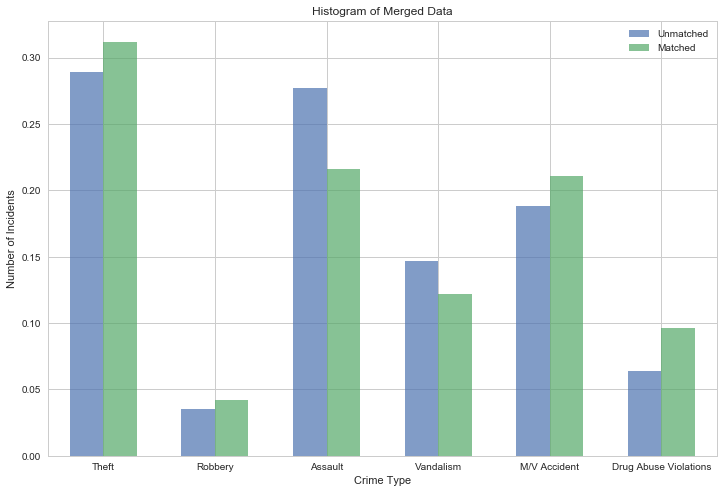

In [94]:
# Check the distribution of crime types for matched and unmatched data
fig, ax = plt.subplots(1,1, figsize=(12,8))

unmatched = df_merge_CP[df_merge_CP['ZIPCODE'].isnull()]['Crime_Type']
matched = df_merge_CP[~df_merge_CP['ZIPCODE'].isnull()]['Crime_Type']

ax.hist(unmatched, bins=np.arange(7)-0.3, density=True, width=0.3, alpha=0.7, label='Unmatched')
ax.hist(matched, bins=np.arange(7), density=True, width=0.3, alpha=0.7, label='Matched')
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(labels=['Theft', 'Robbery', 'Assault', 'Vandalism', 'M/V Accident', 'Drug Abuse Violations'])
ax.set_xlim([-0.5, 5.5])
ax.legend()
ax.set_xlabel('Crime Type')
ax.set_ylabel('Number of Incidents')
ax.set_title('Histogram of Merged Data');

In [95]:
# Drop unmatched data
df_merge_CP = df_m1[~n1].append(df_m2[~n2]).append(df_m3[~n3])
df_merge_CP = df_merge_CP.reset_index(drop=True)

-----

## Create Socialeconomic Dataset

In [59]:
#Create a list of Boston zip codes
zip_codes = [2026.0,2090.0,2108.0,2109.0,2110.0,2111.0,2112.0,2113.0,2114.0,2115.0,2116.0, 2118.0,2119.0,2120.0,
 2121.0,2122.0,2124.0,2125.0,2126.0,2127.0,2128.0,2129.0,2130.0,2131.0,2132.0,2133.0,2134.0,2135.0,2136.0,2137.0,         2186.0,2199.0,
 2201.0,2210.0,2215.0,2445.0,2446.0,2467.0]

In [60]:
#Cover data type to string 
zip_codes_str = ['0'+str(int(i)) for i in zip_codes]

In [61]:
#Using uszipcode package to gather district information, such as population density, total population, median household income 
Pop_den = []
med_house_income = []
Total_pop = []
search = SearchEngine(simple_zipcode=True) 
for zip in zip_codes_str:
    zipcode = search.by_zipcode(zip)
    dict_zip = zipcode.to_dict()
    Pop_den.append(dict_zip['population_density'])
    med_house_income.append(dict_zip['median_household_income'])
    Total_pop.append(dict_zip['population'])

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


In [62]:
#Using uszipcode package to gather district information, such as land area, population_by_age, population_by_gender
search = SearchEngine(simple_zipcode=False) 
younger_population = []
male_population = []
land_area_in_sqmi = []
for zip in zip_codes_str:
    zipcode = search.by_zipcode(zip)
    zipcode = zipcode.to_dict(zipcode)
    land_area_in_sqmi.append(zipcode['land_area_in_sqmi'])
    if (zipcode['population_by_age'] != None):
        young = zipcode['population_by_age'][2]['values'][0:4]
        young = [i['y'] for i in young]
        younger_population.append(sum(young))
        male_population.append(zipcode['population_by_gender'][0]['values'][0]['y'])
    else:
        younger_population.append(zipcode['population_by_age'])
        male_population.append(zipcode['population_by_gender'])

Start downloading data for rich info zipcode database, total size 450+MB ...
  10 MB finished ...
  20 MB finished ...
  30 MB finished ...
  40 MB finished ...
  50 MB finished ...
  60 MB finished ...
  70 MB finished ...
  80 MB finished ...
  90 MB finished ...
  100 MB finished ...
  110 MB finished ...
  120 MB finished ...
  130 MB finished ...
  140 MB finished ...
  150 MB finished ...
  160 MB finished ...
  170 MB finished ...
  180 MB finished ...
  190 MB finished ...
  200 MB finished ...
  210 MB finished ...
  220 MB finished ...
  230 MB finished ...
  240 MB finished ...
  250 MB finished ...
  260 MB finished ...
  270 MB finished ...
  280 MB finished ...
  290 MB finished ...
  300 MB finished ...
  310 MB finished ...
  320 MB finished ...
  330 MB finished ...
  340 MB finished ...
  350 MB finished ...
  360 MB finished ...
  370 MB finished ...
  380 MB finished ...
  390 MB finished ...
  400 MB finished ...
  410 MB finished ...
  420 MB finished ...
  430 MB

In [89]:
#Create Socioeconomic dataset
d = {'ZIPCODE': zip_codes_str, 'Land area':land_area_in_sqmi,'Population Density': Pop_den,'Median household incrom':med_house_income,'Total Population':Total_pop,'Younger Population':younger_population,'Male Population':male_population}
df_Socioeconomic = pd.DataFrame(data=d)


In [90]:
#Calculate percentage of younger population and male population in each zip code district 
df_Socioeconomic['Young_prop'] = df_Socioeconomic['Younger Population']/df_Socioeconomic['Total Population']

In [91]:
df_Socioeconomic.head()

,ZIPCODE,Land area,Population Density,Median household incrom,Total Population,Younger Population,Male Population,Young_prop
0,02026,10.24,2412.0,84704.0,24711.0,5563.0,11950.0,0.225122
1,02090,10.89,1343.0,128984.0,14636.0,4496.0,6971.0,0.307188
2,02108,0.14,27919.0,96921.0,3825.0,690.0,1921.0,0.180392
3,02109,0.17,21721.0,119196.0,3771.0,261.0,1951.0,0.069212
4,02110,0.19,9355.0,111250.0,1733.0,111.0,895.0,0.064051


------

## Merge with Socialeconomic Dataset

In [96]:
df_merge_CPS = pd.merge(df_merge_CP, df_Socioeconomic, how='left', on=['ZIPCODE'])

In [100]:
df_merge_CPS.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,OCCURED_TIME,Crime_Type,Crime_Type_Cat,ST_NAME_1st,ST_NAME_2nd,ST_NAME_SUF,ST_comb,ST_12,ST_1SUF,ZIPCODE,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,GROSS_AREA,LIVING_AREA,NUM_FLOORS,PTYPE_A,PTYPE_C,PTYPE_EO,PTYPE_EP,PTYPE_I,PTYPE_MU,PTYPE_R,YR_BUILT_m,YR_REMOD_m,Land area,Population Density,Median household incrom,Total Population,Younger Population,Male Population,Young_prop
0,I192078623,3802,Motor Vehicle Accident Response,M/V ACCIDENT - PROPERTY DAMAGE,C11,400,NaN,2019-09-28 22:40:00,2019,9,Saturday,22,Part Three,MONTAGUE ST,42.286065,-71.070010,"(42.28606484, -71.07001038)",1900-01-01 22:40:00,4.0,M/V Accident,MONTAGUE,ST,ST,MONTAGUE ST,MONTAGUE ST,MONTAGUE ST,02124,542950.000000,707000.000000,745177.750000,5070.000000,4008.500000,2602.500000,2.125000,0.0,0.0,0.0,0.0,0.0,0.0,4.0,-15.750000,14.000000,3.00,15913.0,48841.0,47783.0,13866.0,21824.0,0.290187
1,I192078599,1402,Vandalism,VANDALISM,B2,238,NaN,2019-09-28 23:21:00,2019,9,Saturday,23,Part Two,WENDOVER ST,42.318827,-71.066054,"(42.31882655, -71.06605368)",1900-01-01 23:21:00,3.0,Vandalism,WENDOVER,ST,ST,WENDOVER ST,WENDOVER ST,WENDOVER ST,02125,288082.500000,413481.000000,476224.800000,3479.850000,4108.300000,2827.650000,2.500000,2.0,0.0,0.0,0.0,0.0,1.0,17.0,-15.944444,-1.000000,2.13,15611.0,45130.0,33295.0,8835.0,16399.0,0.265355
2,I192078586,3802,Motor Vehicle Accident Response,M/V ACCIDENT - PROPERTY DAMAGE,E18,485,NaN,2019-09-28 23:33:00,2019,9,Saturday,23,Part Three,MATTAKEESET ST,42.264837,-71.099668,"(42.26483674, -71.09966819)",1900-01-01 23:33:00,4.0,M/V Accident,MATTAKEESET,ST,ST,MATTAKEESET ST,MATTAKEESET ST,MATTAKEESET ST,02136,285243.478261,426378.260870,449402.826087,5553.869565,3627.173913,2069.565217,1.956522,0.0,0.0,0.0,0.0,0.0,0.0,23.0,-3.347826,-15.000000,4.59,6207.0,58890.0,28488.0,8055.0,13324.0,0.282751
3,I192078583,3801,Motor Vehicle Accident Response,M/V ACCIDENT - OTHER,E18,478,NaN,2019-09-28 23:26:00,2019,9,Saturday,23,Part Three,GREENFIELD RD,42.270801,-71.105812,"(42.27080089, -71.10581184)",1900-01-01 23:26:00,4.0,M/V Accident,GREENFIELD,RD,RD,GREENFIELD RD,GREENFIELD RD,GREENFIELD RD,02126,231282.448276,328715.672414,349293.810345,4681.810345,3011.189655,1668.793103,1.730769,3.0,1.0,0.0,0.0,0.0,0.0,54.0,16.057692,-0.444444,2.08,12277.0,45238.0,25562.0,7076.0,11547.0,0.276817
4,I192078582,3831,Motor Vehicle Accident Response,M/V - LEAVING SCENE - PROPERTY DAMAGE,E13,906,NaN,2019-09-28 22:26:00,2019,9,Saturday,22,Part Three,WALDEN ST,42.325610,-71.104500,"(42.32561013, -71.10449956)",1900-01-01 22:26:00,4.0,M/V Accident,WALDEN,ST,ST,WALDEN ST,WALDEN ST,WALDEN ST,02130,253139.250000,391363.800000,349905.800000,5926.250000,3818.250000,2559.000000,2.666667,8.0,1.0,4.0,0.0,0.0,0.0,7.0,22.666667,-6.222222,3.33,10618.0,75730.0,35401.0,6177.0,16230.0,0.174487


------

## Merge with Lights Dataset

In [104]:
# Function for spherical distance calculation
def spherical_dist(pos1, pos2, r=6371008.7714150598):
    """
    r is in meters
    returns the distance between two coordinates in meters
    pos1: Nx2 matrix with each row a pair of latitude and longitude
    pos2: Nx2 matrix with each row a pair of latitude and longitude
    this assumes a spherical earth, so the distances may be slightly different than geopy but WAY faster!
    """
    pos1 = pos1 * np.pi / 180
    pos2 = pos2 * np.pi / 180
    cos_lat1 = np.cos(pos1[:, 0])
    cos_lat2 = np.cos(pos2[:, 0])
    cos_lat_d = np.cos(pos1[:, 0] - pos2[:, 0])
    cos_lon_d = np.cos(pos1[:, 1] - pos2[:, 1])
    return r * np.arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d))

In [105]:
# Get the vectors of geographic coordinates from light and crime datasets
crime_xy = df_merge_CPS[['Lat', 'Long']].values
light_xy = df_lights[['Lat', 'Long']].values
start_time = time.time()

In [106]:
dist_nearest_light = []
#num_within_100m = []
for i, row in enumerate(crime_xy):
    if i % 10000 == 0 and i > 0:
        #Print message after having done 10000 rounds
        print(f'{i} out of {len(crime_xy)} done in {time.time() - start_time:0.2f}s')

    # vectorizing the operation
    row = row.reshape(-1,2)
    repeated_rows = np.repeat(row, light_xy.shape[0], axis=0)

    spherical_distances = spherical_dist(repeated_rows, light_xy)
    # calculate nearest lamp here using np.min
    min_distance = np.min(spherical_distances)
    dist_nearest_light.append(min_distance)
    
    # calculate num within 100m
    #num_100 = sum(spherical_distances <= 100)
    #num_within_100m.append(num_100)

print(f'{len(crime_xy)} out of {len(crime_xy)} done in {time.time() - start_time:0.2f}s')

10000 out of 142478 done in 52.08s
20000 out of 142478 done in 107.66s
30000 out of 142478 done in 158.30s
40000 out of 142478 done in 207.73s
50000 out of 142478 done in 256.29s
60000 out of 142478 done in 305.38s
70000 out of 142478 done in 353.17s
80000 out of 142478 done in 399.51s
90000 out of 142478 done in 446.05s
100000 out of 142478 done in 496.84s
110000 out of 142478 done in 543.65s
120000 out of 142478 done in 590.73s
130000 out of 142478 done in 640.66s
140000 out of 142478 done in 689.91s
142478 out of 142478 done in 701.57s


In [107]:
#Add the column of distance to the nearest streetlight to the dataset
df_merge_CPS['Dist_to_Nearest_Light'] = dist_nearest_light
#df_merge_CPS['Lights_within_100m'] = num_within_100m

In [109]:
# Save to csv
df_merge_CPS.to_csv("data/df_merge_CPS.csv", encoding='utf-8', index=False)

In [110]:
df_merge_CPS.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,OCCURED_TIME,Crime_Type,Crime_Type_Cat,ST_NAME_1st,ST_NAME_2nd,ST_NAME_SUF,ST_comb,ST_12,ST_1SUF,ZIPCODE,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,GROSS_AREA,LIVING_AREA,NUM_FLOORS,PTYPE_A,PTYPE_C,PTYPE_EO,PTYPE_EP,PTYPE_I,PTYPE_MU,PTYPE_R,YR_BUILT_m,YR_REMOD_m,Land area,Population Density,Median household incrom,Total Population,Younger Population,Male Population,Young_prop,Dist_to_Nearest_Light
0,I192078623,3802,Motor Vehicle Accident Response,M/V ACCIDENT - PROPERTY DAMAGE,C11,400,NaN,2019-09-28 22:40:00,2019,9,Saturday,22,Part Three,MONTAGUE ST,42.286065,-71.070010,"(42.28606484, -71.07001038)",1900-01-01 22:40:00,4.0,M/V Accident,MONTAGUE,ST,ST,MONTAGUE ST,MONTAGUE ST,MONTAGUE ST,02124,542950.000000,707000.000000,745177.750000,5070.000000,4008.500000,2602.500000,2.125000,0.0,0.0,0.0,0.0,0.0,0.0,4.0,-15.750000,14.000000,3.00,15913.0,48841.0,47783.0,13866.0,21824.0,0.290187,7.813019
1,I192078599,1402,Vandalism,VANDALISM,B2,238,NaN,2019-09-28 23:21:00,2019,9,Saturday,23,Part Two,WENDOVER ST,42.318827,-71.066054,"(42.31882655, -71.06605368)",1900-01-01 23:21:00,3.0,Vandalism,WENDOVER,ST,ST,WENDOVER ST,WENDOVER ST,WENDOVER ST,02125,288082.500000,413481.000000,476224.800000,3479.850000,4108.300000,2827.650000,2.500000,2.0,0.0,0.0,0.0,0.0,1.0,17.0,-15.944444,-1.000000,2.13,15611.0,45130.0,33295.0,8835.0,16399.0,0.265355,6.694126
2,I192078586,3802,Motor Vehicle Accident Response,M/V ACCIDENT - PROPERTY DAMAGE,E18,485,NaN,2019-09-28 23:33:00,2019,9,Saturday,23,Part Three,MATTAKEESET ST,42.264837,-71.099668,"(42.26483674, -71.09966819)",1900-01-01 23:33:00,4.0,M/V Accident,MATTAKEESET,ST,ST,MATTAKEESET ST,MATTAKEESET ST,MATTAKEESET ST,02136,285243.478261,426378.260870,449402.826087,5553.869565,3627.173913,2069.565217,1.956522,0.0,0.0,0.0,0.0,0.0,0.0,23.0,-3.347826,-15.000000,4.59,6207.0,58890.0,28488.0,8055.0,13324.0,0.282751,10.215599
3,I192078583,3801,Motor Vehicle Accident Response,M/V ACCIDENT - OTHER,E18,478,NaN,2019-09-28 23:26:00,2019,9,Saturday,23,Part Three,GREENFIELD RD,42.270801,-71.105812,"(42.27080089, -71.10581184)",1900-01-01 23:26:00,4.0,M/V Accident,GREENFIELD,RD,RD,GREENFIELD RD,GREENFIELD RD,GREENFIELD RD,02126,231282.448276,328715.672414,349293.810345,4681.810345,3011.189655,1668.793103,1.730769,3.0,1.0,0.0,0.0,0.0,0.0,54.0,16.057692,-0.444444,2.08,12277.0,45238.0,25562.0,7076.0,11547.0,0.276817,61.418527
4,I192078582,3831,Motor Vehicle Accident Response,M/V - LEAVING SCENE - PROPERTY DAMAGE,E13,906,NaN,2019-09-28 22:26:00,2019,9,Saturday,22,Part Three,WALDEN ST,42.325610,-71.104500,"(42.32561013, -71.10449956)",1900-01-01 22:26:00,4.0,M/V Accident,WALDEN,ST,ST,WALDEN ST,WALDEN ST,WALDEN ST,02130,253139.250000,391363.800000,349905.800000,5926.250000,3818.250000,2559.000000,2.666667,8.0,1.0,4.0,0.0,0.0,0.0,7.0,22.666667,-6.222222,3.33,10618.0,75730.0,35401.0,6177.0,16230.0,0.174487,4.517171
